In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
# from models import *
# from fastai import *
from fastai.vision import *
from fastai.callbacks.hooks import *
from fastai.callbacks import LossMetrics
import tqdm
import os

In [3]:
import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
path=Path('/home/staff/xin/Downloads/leafdisease/test/')

In [5]:
src=ImageList.from_folder(path).split_by_rand_pct(0.3,seed=2).label_from_folder()

In [6]:
data=(src.transform(get_transforms(),size=224).databunch(bs=16).normalize(imagenet_stats))

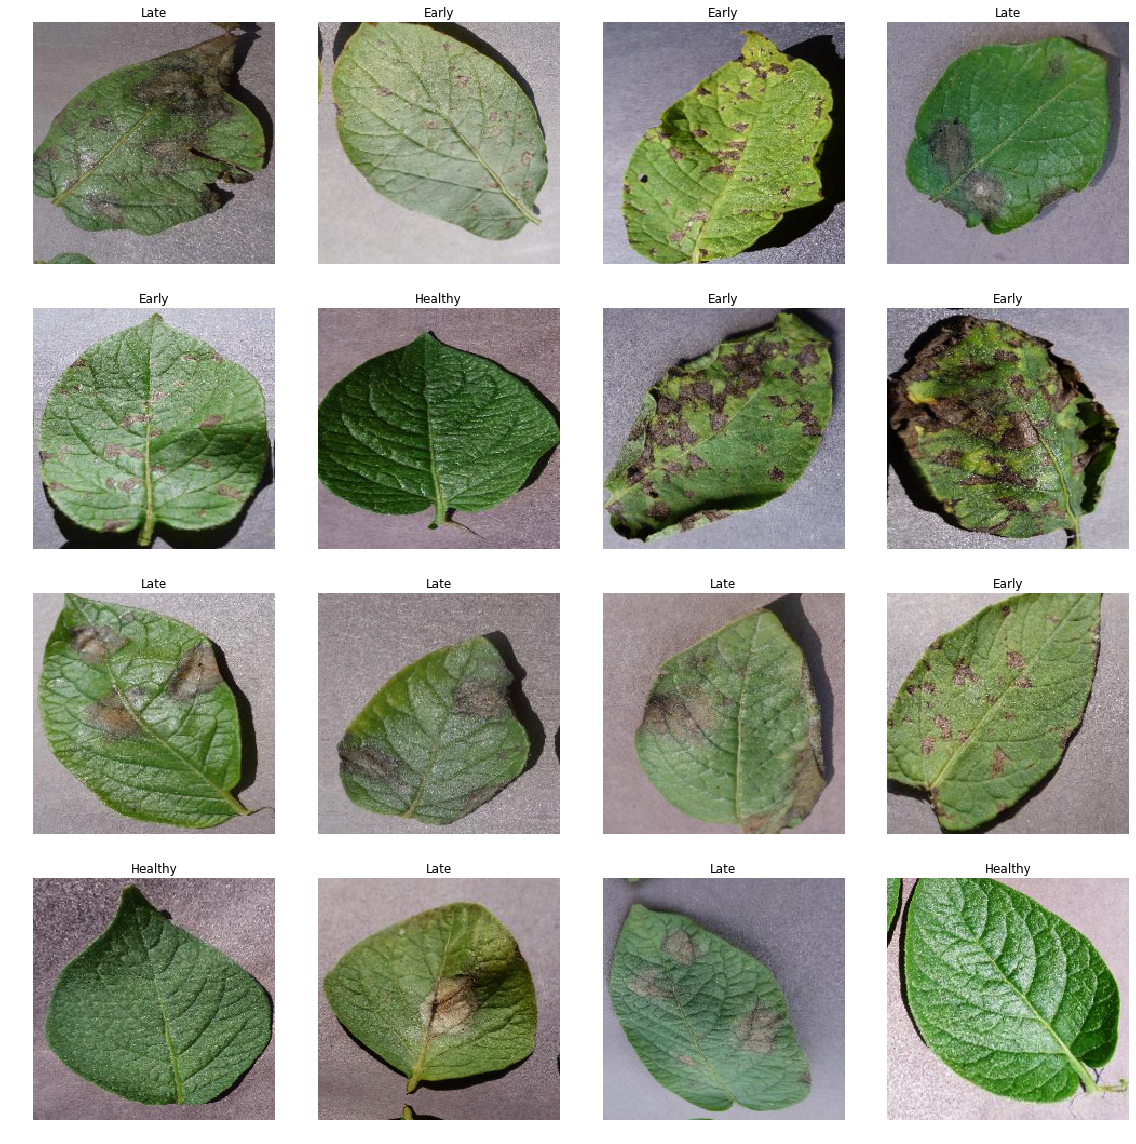

In [8]:
data.show_batch()

In [7]:
from model import Inception3

In [8]:
class FeatureLoss(nn.Module):
    def __init__(self):
        super().__init__()
        self.loss_cross_entropy = nn.CrossEntropyLoss()
        self.loss_func = nn.BCEWithLogitsLoss()
        self.interp = nn.Upsample(size=(224,224), mode='bilinear')
        self.metric_names = ['loss_cls','loss_side3','loss_side4','loss_back']
    
     
#     def interp(self,inputs):
#         return F.interpolate(inputs,size=(224,224), mode='bilinear')
        
    def normalize_atten_maps(self, atten_maps):
        atten_shape = atten_maps.size()

        #--------------------------
        batch_mins, _ = torch.min(atten_maps.view(atten_shape[0:-2] + (-1,)), dim=-1, keepdim=True)
        batch_maxs, _ = torch.max(atten_maps.view(atten_shape[0:-2] + (-1,)), dim=-1, keepdim=True)
        atten_normed = torch.div(atten_maps.view(atten_shape[0:-2] + (-1,))-batch_mins,
                                 batch_maxs - batch_mins)
        atten_normed = atten_normed.view(atten_shape)

        return atten_normed


    def get_atten_map(self, feature_maps, gt_labels, normalize=True):
        label = gt_labels.long()

        feature_map_size = feature_maps.size()
        batch_size = feature_map_size[0]

        atten_map = torch.zeros([feature_map_size[0], feature_map_size[2], feature_map_size[3]])
        atten_map = atten_map.cuda()
        for batch_idx in range(batch_size):
            atten_map[batch_idx,:,:] = torch.squeeze(feature_maps[batch_idx, label.data[batch_idx], :,:])

        if normalize:
            atten_map = self.normalize_atten_maps(atten_map)

        return atten_map
    def mark_obj(self, label_img, heatmap, label, threshold=0.5):

        if isinstance(label, (float, int)):
            np_label = label
        else:
            np_label = label.cpu().data.numpy().tolist()

        for i in range(heatmap.size()[0]):
            mask_pos = heatmap[i] > threshold
            if torch.sum(mask_pos.float()).data.cpu().numpy() < 30:
                threshold = torch.max(heatmap[i]) * 0.7
                mask_pos = heatmap[i] > threshold
            label_i = label_img[i]
            if isinstance(label, (float, int)):
                use_label = np_label
            else:
                use_label = np_label[i]
            # label_i.masked_fill_(mask_pos.data, use_label)
            label_i[mask_pos.data] = use_label
            label_img[i] = label_i

        return label_img

    def mark_bg(self, label_img, heatmap, threshold=0.1):
        mask_pos = heatmap < threshold
        # label_img.masked_fill_(mask_pos.data, 0.0)
        label_img[mask_pos.data] = 0.0

        return label_img

    def get_mask(self, mask, atten_map, th_high=0.7, th_low = 0.05):
        #mask label for segmentation
        mask = self.mark_obj(mask, atten_map, 1.0, th_high)
        mask = self.mark_bg(mask, atten_map, th_low)

        return  mask

    def loss_saliency(self, loss_func, logtis, labels):
        positions = labels.view(-1, 1) < 255.0
        return self.loss_func(logtis.view(-1, 1)[positions], labels.view(-1, 1)[positions])


    def loss_segmentation(self, loss_func, logits, labels):
        logits = logits.permute(0, 2, 3, 1).contiguous().view((-1, self.num_classes+1))
        labels = labels.view(-1).long()

        return self.loss_func(logits, labels)

    
    def forward(self, inputs, gt_labels):
        out1, side3, side4, out_seg= inputs
        logits_1 = torch.mean(torch.mean(out1, dim=2), dim=2)
#         print(out1.shape)
        atten_map = self.get_atten_map(self.interp(out1), gt_labels, True)

        loss_cls = self.loss_cross_entropy(logits_1, gt_labels.long())

        # atten_map = logits[-1]
        mask = torch.zeros((logits_1.size()[0], 224, 224)).fill_(255).cuda()
        mask = self.get_mask(mask, atten_map)

        mask_side4 = torch.zeros((logits_1.size()[0], 224, 224)).fill_(255).cuda()
        mask_side4 = self.get_mask(mask_side4, torch.squeeze(torch.sigmoid(self.interp(side4))), 0.5, 0.05)

        loss_side4 = self.loss_saliency(self.loss_func, self.interp(side4).squeeze(dim=1), mask)
        loss_side3 = self.loss_saliency(self.loss_func, self.interp(side3).squeeze(dim=1), mask_side4)

        fused_atten = (torch.sigmoid(self.interp(side3)) + torch.sigmoid(self.interp(side4)))/2.0

        back_mask = torch.zeros((logits_1.size()[0], 224, 224)).fill_(255).cuda()
        back_mask = self.get_mask(back_mask, torch.squeeze(fused_atten.detach()), 0.7, 0.1)
        loss_back = self.loss_saliency(self.loss_func, self.interp(out_seg).squeeze(dim=1), back_mask)

        loss_val = loss_cls + loss_side3 + loss_side4 + loss_back
#         print(loss_cls,loss_side3,loss_side4,loss_back)
        outloss=[loss_cls,loss_side3,loss_side4,loss_back]       
        self.metrics=dict(zip(self.metric_names, outloss))
#         print(self.metrics)
        return loss_val
        

In [9]:
lossfunc=FeatureLoss()

In [10]:
gc.collect()
learn=None
model=None

In [11]:
model= Inception3(num_classes=3,threshold=0.6)

In [12]:
def acc_camvid(input, target):
    out1,_,_,_= input
    logits_1 = torch.mean(torch.mean(out1, dim=2), dim=2)
    return accuracy(logits_1,target)

In [13]:
learn=Learner(data,model,loss_func=lossfunc,metrics=acc_camvid,callback_fns=LossMetrics)

# learn=Learner(data,model,loss_func=lossfunc)

In [29]:
learn.unfreeze()

/home/staff/xin/miniconda3/envs/py3/lib/python3.7/site-packages/torch/nn/modules/upsampling.py:129: UserWarning: nn.Upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.{} is deprecated. Use nn.functional.interpolate instead.".format(self.name))
/home/staff/xin/miniconda3/envs/py3/lib/python3.7/site-packages/torch/nn/functional.py:2423: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


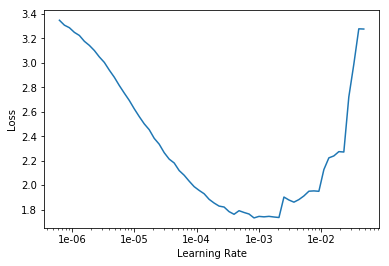

In [16]:
lr_find(learn)
learn.recorder.plot()

In [30]:
lr=1e-4

In [31]:
learn.fit_one_cycle(30,slice(lr))

epoch,train_loss,valid_loss,acc_camvid,loss_cls,loss_side3,loss_side4,loss_back,time
0,0.872988,0.655732,0.841941,0.560301,0.010173,0.084017,0.001241,00:39
1,0.607345,0.354101,0.899844,0.274949,0.001937,0.076769,0.000446,00:40
2,0.456684,0.240135,0.946792,0.154073,0.000419,0.085320,0.000323,00:40
3,0.398259,0.229434,0.962441,0.103343,0.000100,0.125744,0.000247,00:40
4,0.343062,0.255632,0.945227,0.142915,0.000828,0.111854,0.000035,00:40
5,0.487839,0.319116,0.956182,0.102523,0.137596,0.078991,0.000007,00:40
6,0.652728,1.376179,0.871674,0.959919,0.187491,0.205178,0.023590,00:40
7,0.565479,0.368479,0.974961,0.069569,0.122242,0.063178,0.113491,00:39
8,0.539776,0.246382,0.979656,0.060383,0.088364,0.083594,0.014041,00:39
9,0.500446,0.295318,0.968701,0.090781,0.107877,0.073264,0.023396,00:39


/home/staff/xin/miniconda3/envs/py3/lib/python3.7/site-packages/torch/nn/modules/upsampling.py:129: UserWarning: nn.Upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.{} is deprecated. Use nn.functional.interpolate instead.".format(self.name))
/home/staff/xin/miniconda3/envs/py3/lib/python3.7/site-packages/torch/nn/functional.py:2423: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


In [60]:
learn.save('final')

In [14]:
learn.load('final')

/home/staff/xin/miniconda3/envs/py3/lib/python3.7/site-packages/torch/serialization.py:251: UserWarning: Couldn't retrieve source code for container of type FeatureLoss. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


Learner(data=ImageDataBunch;

Train: LabelList (1492 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
Late,Late,Late,Late,Late
Path: /home/staff/xin/Downloads/leafdisease/test;

Valid: LabelList (639 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
Early,Early,Early,Early,Late
Path: /home/staff/xin/Downloads/leafdisease/test;

Test: None, model=Inception3(
  (Conv2d_1a_3x3): BasicConv2d(
    (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2a_3x3): BasicConv2d(
    (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2b_3x3): BasicConv2d(
    (conv): Conv2d(3

In [15]:
def normalize_atten_maps(atten_maps):
    atten_shape = atten_maps.size()

    #--------------------------
    batch_mins, _ = torch.min(atten_maps.view(atten_shape[0:-2] + (-1,)), dim=-1, keepdim=True)
    batch_maxs, _ = torch.max(atten_maps.view(atten_shape[0:-2] + (-1,)), dim=-1, keepdim=True)
    atten_normed = torch.div(atten_maps.view(atten_shape[0:-2] + (-1,))-batch_mins,
                             batch_maxs - batch_mins)
    atten_normed = atten_normed.view(atten_shape)
    return atten_normed
def get_localization_maps(inputs):
    map1 = normalize_atten_maps(inputs)
    # map_erase = self.normalize_atten_maps(self.map_erase)
    # return torch.max(map1, map_erase)
    return map1

In [16]:
sz=[224,224]

In [99]:
idx=np.random.randint(1492)
test=data.train_ds[idx]
inputs=learn.data.one_item(test[0])
logits=learn.model(inputs[0])
last_featmaps = get_localization_maps(logits[3])

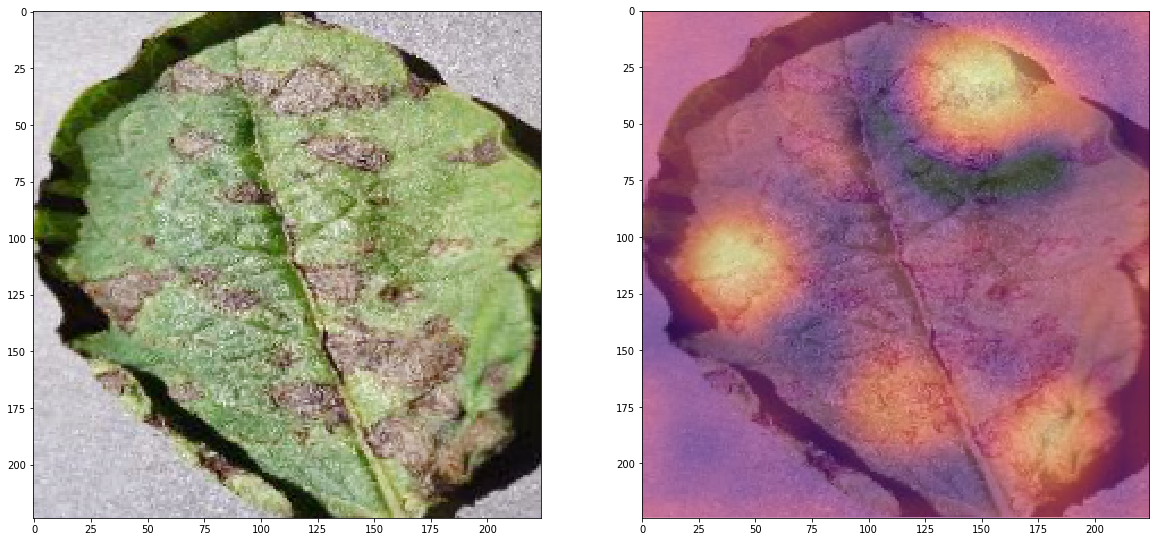

In [100]:
plt.figure(figsize=(20,10))
plt.subplot(121)
plt.imshow(test[0].data.numpy().transpose(1,2,0))
plt.subplot(122)
plt.imshow(test[0].data.numpy().transpose(1,2,0))
plt.imshow(last_featmaps[0,0], alpha=0.6, extent=(0,*sz[::-1],0), interpolation='bilinear', cmap='magma')
# plt.subplot(143)
# plt.imshow(test[0].data.numpy().transpose(1,2,0))
# plt.imshow(last_featmaps[0,1], alpha=0.6, extent=(0,*sz[::-1],0), interpolation='bilinear', cmap='magma')
# plt.subplot(144)
# plt.imshow(test[0].data.numpy().transpose(1,2,0))
# plt.imshow(last_featmaps[0,2], alpha=0.6, extent=(0,*sz[::-1],0), interpolation='bilinear', cmap='magma')